In [9]:
! pip install my-torch
# In case the fancy dict truc doesn't work

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from run import Runner
from mytorch.utils.goodies import FancyDict
from matplotlib import pyplot as plt
import numpy as np

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/hchoi/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
args = {'name' : 'testrun',
'dataset' : 'RLF/data_lf',
'model' : 'compgcn',
'score_func' : 'conve',
'opn' : 'corr',                 
'use_wandb' : False, 
'batch_size' : 128,       
'gamma' : 40.0,			
'gpu' : '0',			
'max_epochs' : 500,  	
'l2' : 0.0,			
'lr' : 0.001,			
'lbl_smooth' : 0.1,	
'num_workers' : 10,                     
'seed' : 41504,     	
'restore' : True,            
'bias' : False   ,         
'num_bases' : -1, 	
'init_dim' : 100,	
'gcn_dim' : 200 ,	
'embed_dim' : None, 	
'gcn_layer' : 1 	,
'dropout' : 0.1	,
'hid_drop' : 0.3	,
'hid_drop2' : 0.3	,
'feat_drop' : 0.3	,
'k_w' : 10 	,
'k_h' : 20 	,
'num_filt' : 200, 	
'ker_sz' : 7 	,
'log_dir' : './log/',               
'config_dir' : './config/',
'trim' : False, 
'use_fasttext' : False
}
args = FancyDict(args)

model = Runner(args)

2023-07-19 13:41:16,650 - [INFO] - {}
{}


In [3]:
model.p

{'name': 'testrun',
 'dataset': 'RLF/data_lf',
 'model': 'compgcn',
 'score_func': 'conve',
 'opn': 'corr',
 'use_wandb': False,
 'batch_size': 128,
 'gamma': 40.0,
 'gpu': '0',
 'max_epochs': 500,
 'l2': 0.0,
 'lr': 0.001,
 'lbl_smooth': 0.1,
 'num_workers': 10,
 'seed': 41504,
 'restore': True,
 'bias': False,
 'num_bases': -1,
 'init_dim': 100,
 'gcn_dim': 200,
 'embed_dim': 200,
 'gcn_layer': 1,
 'dropout': 0.1,
 'hid_drop': 0.3,
 'hid_drop2': 0.3,
 'feat_drop': 0.3,
 'k_w': 10,
 'k_h': 20,
 'num_filt': 200,
 'ker_sz': 7,
 'log_dir': './log/',
 'config_dir': './config/',
 'trim': False,
 'use_fasttext': False,
 'num_ent': 26558,
 'num_rel': 94}

In [4]:
# Now load the saved model
model.load_model('./checkpoints/compgcn-conve-rlffam')

In [8]:
model.ent2id['soleil i.a'] # Voila ca marche

1436

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.manifold import TSNE

In [6]:
assert len(model.ent2id) == model.model.init_embed.data.shape[0], "The numbers don't add up, something feels weird"

In [24]:
def visualize(
    model, # Runner object
    words = [], # If None, visualize everything
    words2 = [], # If given, we can color them differently
    use_tsne_not_pca = True, # If False, we use PCA
    label_every_dot = True # Make it false if word lists are too large
):
    
    embeddings = model.model.init_embed.data.cpu().numpy()

    if words2 and not words:
        raise ValueError(f'Words is None, and Words2 is not None. Ca marche pas.')
        
    if not words and not words2:
        # we visualize everything
        vecs = model.model.init_embed.data.cpu().numpy()
    else:
        # we visualize a few node vectors
        node_ids = [model.ent2id[word] for word in words]
        if words2:
            node_ids_2 = [model.ent2id[word] for word in words2]
            y = [0]*len(node_ids) + [1]*len(node_ids_2)
        else:
            node_ids_2, y = [], None
        vecs = np.asarray([embeddings[node_id] for node_id in node_ids+node_ids_2])
            
    # Ok we have vectors now. Let's fit
    if use_tsne_not_pca:
        tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3) 
        z = tsne.fit_transform(vecs)
    else:
        z = PCA().fit_transform(vecs)[:,:2]
        
    # Now to plot everything
    df = pd.DataFrame()
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]
    
    # Case 1: no need for different colors, we just throw the entire thing out.
    if not words2:
        plt = sns.scatterplot(x="comp-1", y="comp-2", palette=sns.color_palette("hls", 3),
                    data=df)
    # Case 2: yes we are comparing two group of words
    else:
        assert y, "y should not be none"
        df["y"] = y
        plt = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df)
    
    plt.set(title=f"{'T-SNE' if use_tsne_not_pca else 'PCA'} projection of Node Vectors") 
    
    # Do we label every dot?
    if label_every_dot and words:
        # Compute x and y offset based on magnitude of vectors
        xo = (df['comp-1']**2).sum()**0.5/len(df['comp-1'])/20
        yo = (df['comp-2']**2).sum()**0.5/len(df['comp-1'])/20
        
        # We have to label at least one set of words.
        for word, (x,y) in zip(words+words2, z):
            plt.text(x+xo, y+yo, word)

In [20]:
# Visualize everything
visualize(model)

KeyboardInterrupt: 

/tmp/ipykernel_284140/434915941.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt = sns.scatterplot(x="comp-1", y="comp-2", palette=sns.color_palette("hls", 3),


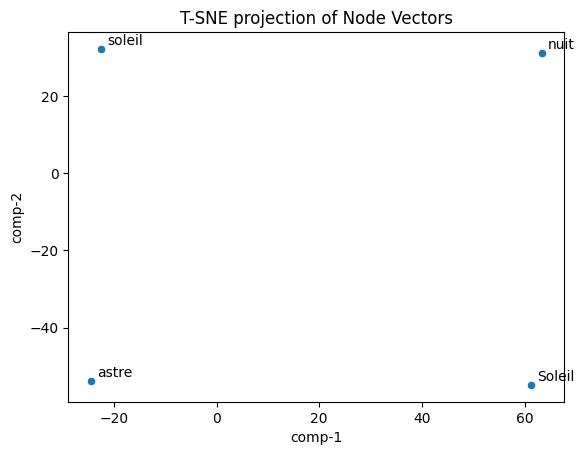

In [26]:
# Visualize one set of words, with labels
words1 = ['soleil', 'Soleil', 'astre', 'nuit']
visualize(model, words=words1)

/tmp/ipykernel_284140/434915941.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt = sns.scatterplot(x="comp-1", y="comp-2", palette=sns.color_palette("hls", 3),


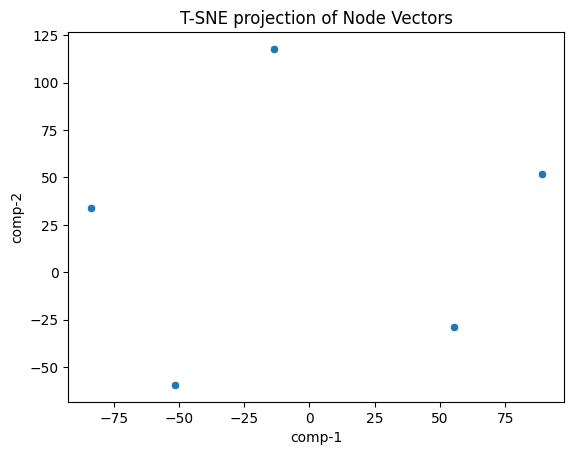

In [27]:
# Visualize one set of words, WITHOUT labels
words1 = ['confiture', 'jambon', 'sandwich', 'pâté', 'fromage']
visualize(model, words=words1, label_every_dot=False)

/tmp/ipykernel_284140/434915941.py:47: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  plt = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


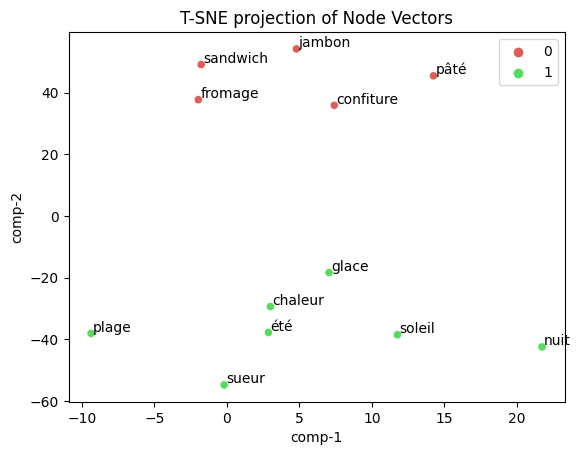

In [28]:
# T-SNE over two set of words
words1 = ['confiture', 'jambon', 'sandwich', 'pâté', 'fromage']
words2 = ['soleil', 'nuit', 'chaleur', 'été', 'sueur', 'glace', 'plage']
visualize(model, words=words1, words2=words2)

/tmp/ipykernel_9297/1621071938.py:46: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  plt = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


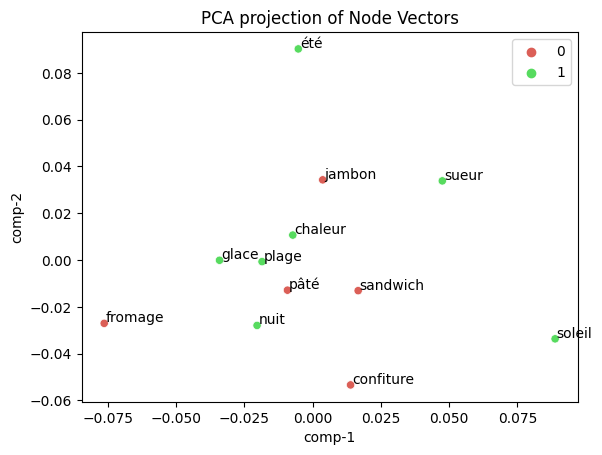

In [105]:
# Same but PCA
# T-SNE over two set of words
words1 = ['confiture', 'jambon', 'sandwich', 'pâté', 'fromage']
words2 = ['soleil', 'nuit', 'chaleur', 'été', 'sueur', 'glace', 'plage']
visualize(model, words=words1, words2=words2, use_tsne_not_pca=False)

In [11]:
from numpy.linalg import norm
from numpy import dot

def cosine(v1, v2):
  """
  cosine similarity of two vectors
  NB: Standard metric to measure similarity between word vectors
  
  Hint: look at the imports in cell above ;)
  """
  return dot(v1, v2)/(norm(v1)*norm(v2))


class NodeVectors:
    
    def __init__(self, vocab, vectors):
        self.vocab = vocab
        self.vectors = vectors
        self._dim = self.vectors.shape[0]
        self.zerovec = np.zeros((self._dim), dtype=float)
        
        self._norm = norm(vectors, axis=1)
        self.id_to_tok = {i:tok for tok, i in vocab.items()}
        
    def safely_vectorize(self, toks):
        return [self.vectors[self.vocab[tok]] for tok in toks if tok in self.vocab]
        
    def __call__(self, k):
        # If token exists 
        if k in self.vocab:
            return self.vectors[self.vocab[k]]
        elif k.lower() in self.vocab:
            return self.vectors[self.vocab[k.lower()]]
        elif k[0].upper()+k[1:].lower() in self.vocab:
            return self.vectors[self.vocab[k[0].upper()+k[1:].lower()]]
        else:
            return self.zerovec
        
    def __len__(self):
        return len(self.vocab)
    
    def most_similar(self, word, k: 10, normalize=True):
        if isinstance(word, str):
            wid = self.vocab.get(word, -1)
            if wid < 0:
                return None
            v = self.vectors[wid]
        elif isinstance(word, np.ndarray) and len(word.shape) == 1:
            v = word
        else:
            raise TypeError(f"Unknown Type of word: {type(word)} ")
            
        cosines = np.dot(self.vectors, v) 
        if normalize:
            cosines = cosines / self._norm / norm(v)
        cosines_ind = np.argsort(-cosines)[:k]
        return [(self.id_to_tok[tokid], cosines[tokid]) for tokid in cosines_ind]
    
    def analogy2(self, wa, wb, wc, k=10):
        if wa in self.vocab and wb in self.vocab and wc in self.vocab:

            diff = self(wa) - self(wb) + self(wc)
            dists = sorted([(tok, float(norm(diff - self.vectors[i]))) for tok, i in self.vocab.items() if not tok in [wa, wb, wc]], key=lambda x: x[1])
            
            return dists[:k]
        else:
            return None
        
    def analogy(self, wa, wb, wc, k=10):
        if wa in self.vocab and wb in self.vocab and wc in self.vocab:

            diff = self(wb) + self(wc) - self(wa)
            dists = sorted([(tok, float(norm(diff - self.vectors[i]))) for tok, i in self.vocab.items() if not tok in [wa, wb, wc]], key=lambda x: x[1])
            
            return dists[:k]
        else:
            return None
        

In [12]:
nvs = NodeVectors(vocab=model.ent2id, vectors=model.model.init_embed.data.cpu().numpy())

In [13]:
# Get vector for one word
nvs('soleil i.a')

array([-1.1127e-01,  2.1707e-01, -1.4263e-01,  1.0431e-01, -3.9017e-02,
        3.3799e-01,  6.5016e-02,  2.3465e-01, -1.0414e-01,  1.8052e-01,
       -3.3003e-01,  1.0506e-02, -2.3010e-01,  2.2891e-01,  1.0796e-01,
        2.6514e-01,  1.4356e-01,  2.2604e-01,  1.3465e-01, -1.2029e-01,
        5.0176e-02,  3.3264e-01,  3.8417e-02,  2.3094e-02, -4.8243e-02,
       -1.1678e-02,  9.0891e-02, -2.4439e-01,  7.0311e-02, -8.8052e-02,
       -6.8158e-02,  1.0667e-01,  4.0149e-01,  2.1229e-01, -3.3479e-01,
       -3.3882e-01, -1.5504e-02, -3.2397e-01, -2.0430e-01, -3.4725e-02,
       -1.3037e-01, -4.1331e-01, -2.1929e-04,  3.3355e-02, -1.1231e-01,
        8.1123e-02, -4.4309e-01,  1.2323e-01, -3.4146e-01, -3.8406e-01,
       -4.1614e-01, -2.6354e-01,  5.5499e-01, -9.5210e-03, -1.4968e-01,
        5.9890e-02,  8.4752e-02,  1.1542e-01, -8.3919e-02, -4.4864e-01,
       -5.8676e-01, -2.4831e-01,  2.9652e-01,  2.9210e-01,  6.4361e-02,
       -5.7670e-02,  7.7224e-02, -3.1937e-02,  1.3731e-01, -2.26

In [129]:
# Get cosine between vectors
print(f"Cosine of 'doctorat', and 'inutile' is {cosine(nvs('doctorat'), nvs('inutile')):.4f}")


Cosine of 'doctorat', and 'idiot' is 0.0439


In [14]:
# Similarity 
# 1- computing the cosine between the vector of 'dog' and all the other words
# 2- get the top-10 most similar words 
# most_similar does those two steps 
nvs.most_similar('soleil i.a', 20)



[('soleil i.a', 1.0),
 ('astre du jour', 0.64188623),
 ('soleil i.b', 0.6048301),
 ('lune i.1b', 0.5977887),
 ('rayon i', 0.5680933),
 ('terre ii.1', 0.55507714),
 ('système solaire', 0.5409041),
 ('vénus iii', 0.5366093),
 ('lune i.1a', 0.5291988),
 ('lunaire adj', 0.51765096),
 ('croissant i', 0.50527173),
 ('étoilé', 0.47816172),
 ('solaire adj', 0.47443476),
 ('nuit i', 0.45626858),
 ('titre de participation', 0.45560774),
 ('céleste i', 0.44801575),
 ('gaz naturel', 0.44324565),
 ('terre i', 0.44255677),
 ('zélande', 0.43526775),
 ('gaz de ville', 0.4324877)]